In [1]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from Utils.Optuna import optuna_hyperparameter_tuning
import numpy as np
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
import optuna
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
import pandas as pd
from catboost import CatBoostRegressor, Pool
import numpy as np
from pipeline import Pipeline

2024-03-20 17:45:03.980 | INFO     | preprocessing.abstract_prep:<module>:6 - Successfully imported file
2024-03-20 17:45:03.981 | INFO     | preprocessing.check_nans:<module>:7 - Successfully imported file
2024-03-20 17:45:03.981 | INFO     | preprocessing.minmax_scaler:<module>:8 - Successfully imported 'MinMaxScaler' file
2024-03-20 17:45:03.999 | INFO     | preprocessing.check_and_remove_outliers:<module>:6 - Successfully imported 'CheckAndRemoveOutliers' file


In [2]:
data = pd.read_csv("Data/cleaned_data.csv")
columns = pd.read_json("Data/selected_features_15.json")[0]

In [3]:
pipeline = Pipeline(data, CatBoostRegressor)
data_preprocessed = pipeline.data_preprocessing(data)
X = data_preprocessed[columns]
y = data_preprocessed['CREDIT_SCORE']
X.shape

2024-03-20 17:45:04.072 | INFO     | pipeline:data_preprocessing:19 - Data Preprocessing
2024-03-20 17:45:04.073 | INFO     | preprocessing.check_nans:transform:15 - CheckNans is starting
2024-03-20 17:45:04.075 | INFO     | preprocessing.check_nans:transform:18 - No NaNs in dataframe
2024-03-20 17:45:04.146 | INFO     | preprocessing.check_and_remove_outliers:transform:33 - Number of outliers in dataframe: 23
2024-03-20 17:45:04.148 | ERROR    | preprocessing.minmax_scaler:transform:42 - _MinMaxScaler preprocessing class_ is not fitted yet. Please call 'fit' with training data before transforming.
2024-03-20 17:45:04.151 | INFO     | preprocessing.minmax_scaler:transform:53 - _MinMaxScaler preprocessing class_ is starting transformation
2024-03-20 17:45:04.155 | INFO     | preprocessing.minmax_scaler:transform:56 - _MinMaxScaler preprocessing class_ transformation ended
2024-03-20 17:45:04.155 | INFO     | pipeline:data_preprocessing:28 - Data Preprocessing completed


(803, 37)

In [4]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_eval.shape, y_eval.shape

((577, 37), (577,), (161, 37), (161,), (65, 37), (65,))

<Axes: xlabel='CREDIT_SCORE', ylabel='Count'>

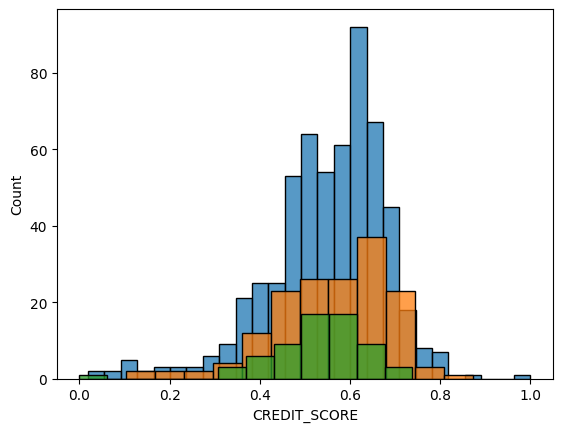

In [5]:
import seaborn as sns
sns.histplot(y_train)
sns.histplot(y_valid)
sns.histplot(y_eval)

In [6]:
# def objective(trial):
#     param = {}
#     param['learning_rate'] = trial.suggest_loguniform("learning_rate", 0.001, 1)
#     param['depth'] = trial.suggest_int('depth', 3, 15)
#     param['l2_leaf_reg'] = trial.suggest_loguniform('l2_leaf_reg', 0.01, 10)
#     param['min_child_samples'] = trial.suggest_int('min_child_samples', 1, 50)
#     param['grow_policy'] = 'Depthwise'
#     param['iterations'] = trial.suggest_int('iterations', 100, 2000)
#     param['use_best_model'] = True
#     param['eval_metric'] = 'RMSE'
#     param['od_type'] = 'iter'
#     param['od_wait'] = 20
#     param['logging_level'] = 'Silent'
    
#     regressor = CatBoostRegressor(**param)

#     regressor.fit(X_train.copy(), y_train.copy(),
#                   eval_set=[(X_eval.copy(), y_eval.copy())],
#                   early_stopping_rounds=10)
#     loss = mean_squared_error(y_valid, regressor.predict(X_valid.copy()))
#     return loss


In [7]:
# {
#     'learning_rate': 0.6063757568124354,
#     'depth': 6,
#     'l2_leaf_reg': 7.17402991755073,
#     'min_child_samples': 32,
#     'iterationsc': 835
# }

In [8]:
import optuna
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def objective(trial):
    params = {
        'learning_rate': trial.suggest_loguniform("learning_rate", 0.001, 1),
        'depth': trial.suggest_int('depth', 3, 15),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 0.01, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 50),
        'grow_policy': 'Depthwise',
        'iterations': trial.suggest_int('iterations', 100, 2000),
        'use_best_model': True,
        'eval_metric': 'RMSE',
        'od_type': 'iter',
        'od_wait': 20,
        'logging_level': 'Silent'
    }
    
    regressor = CatBoostRegressor(**params)
    
    regressor.fit(
        X_train, y_train,
        eval_set=[(X_eval, y_eval)],
        early_stopping_rounds=10,
        verbose=False
    )
    
    y_pred = regressor.predict(X_valid)
    loss = mean_squared_error(y_valid, y_pred)
    
    return loss

study = optuna.create_study(study_name='catboost_optimization', direction='minimize')
study.optimize(objective, n_trials=100, n_jobs=-1)

if len(study.trials) > 0:
    print("Best trial:")
    best_trial = study.best_trial
    print("  Value: {}".format(best_trial.value))
    print("  Params: ")
    for key, value in best_trial.params.items():
        print("    {}: {}".format(key, value))
else:
    print("No trials have been completed.")


[I 2024-03-20 17:45:04,438] A new study created in memory with name: catboost_optimization
/tmp/ipykernel_14510/3575587929.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform("learning_rate", 0.001, 1),
/tmp/ipykernel_14510/3575587929.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 0.01, 10),
[I 2024-03-20 17:45:05,040] Trial 8 finished with value: 0.004854934883720637 and parameters: {'learning_rate': 0.42754047186284994, 'depth': 7, 'l2_leaf_reg': 0.7315063516439443, 'min_child_samples': 31, 'iterations': 635}. Best is trial 8 with value: 0.004854934883720637.
/tmp/ip

Best trial:
  Value: 0.003627893534849309
  Params: 
    learning_rate: 0.010915165026927024
    depth: 11
    l2_leaf_reg: 0.9010947650779054
    min_child_samples: 50
    iterations: 1316


In [9]:
# %%time
# study = optuna.create_study(study_name=f'catboost-seed{42}')
# study.optimize(objective, n_trials=5000, n_jobs=-1, timeout=2400)

In [10]:
study.best_value

0.003627893534849309

In [11]:
study.best_params


{'learning_rate': 0.010915165026927024,
 'depth': 11,
 'l2_leaf_reg': 0.9010947650779054,
 'min_child_samples': 50,
 'iterations': 1316}

In [12]:
# {
#     'learning_rate': 0.6063757568124354,
#     'depth': 6,
#     'l2_leaf_reg': 7.17402991755073,
#     'min_child_samples': 32,
#     'iterations': 835
# }
# Training set metrics:
# 0.0020861356718066227
# 0.8788832890998062
# 0.03443580505288086
# 0.04567423422244343
# Validation set metrics:
# 0.0035043265612778513
# 0.7912041150041146
# 0.041729216269541645
# 0.05919735265430247
# 993.3872607256602
# predicted = MinMaxScaling().inverse_transform(pred_valid)
# actual = MinMaxScaling().inverse_transform(y_valid)
# print(mean_squared_error(actual, predicted))
# print(r2_score(actual, predicted))
# print(mean_absolute_error(actual, predicted))
# print(np.sqrt(mean_squared_error(actual, predicted)))
# 0.7804104782312765
# 22.93352241907153
# 31.51804658803683

In [13]:
%%time
optimized_regressor = CatBoostRegressor(learning_rate=0.0037945676929392693,
                                        depth=3,
                                        l2_leaf_reg=0.17795008128571876,
                                        min_child_samples=43,
                                        grow_policy='Depthwise',
                                        iterations=1254,
                                        use_best_model=True,
                                        eval_metric='RMSE',
                                        od_type='iter',
                                        od_wait=20,
                                        random_state=42,
                                        logging_level='Silent'
                                        )
optimized_regressor.fit(X_train.copy(), y_train.copy(),
                        eval_set=[(X_eval.copy(), y_eval.copy())],
                        plot=True,
                        early_stopping_rounds=10)
pred_train = optimized_regressor.predict(X_train.copy())
pred_valid = optimized_regressor.predict(X_valid.copy())

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CPU times: user 6.1 s, sys: 985 ms, total: 7.08 s
Wall time: 1.09 s


In [14]:
optimized_regressor.tree_count_

1253

In [15]:
optimized_regressor.get_best_iteration()

1252

In [16]:
# tree_structure = best_regressor.get_feature_importance(type='FeatureImportance')
# print("Tree Structure:")
# print(tree_structure)
# features = range(X_train.shape[1])  

# plt.figure(figsize=(10, 8))
# plt.bar(features, feature_importances)
# plt.xlabel('Feature Index')
# plt.ylabel('Importance')
# plt.title('Feature Importance')
# plt.xticks(ticks=features, labels=[f"F{str(i)}" for i in features], rotation=90)
# plt.show()

In [17]:
import pandas as pd
import json

# Load scaling parameters
with open("Data/scaling_values.json") as f:
    scaling_params = json.load(f)

# Correct descale function
def descale_feature(feature_name, scaled_value):
    min_val, max_val = scaling_params[feature_name]
    return scaled_value * (max_val - min_val) + min_val

def descale_features(X_valid_scaled, scaling_params):
    X_descaled = X_valid_scaled.copy()
    for feature_name in X_descaled.columns:
        # Use apply to vectorize the descaling across the column
        X_descaled[feature_name] = X_descaled[feature_name].apply(lambda x: descale_feature(feature_name, x))
    return X_descaled

# Descale X_valid
X_valid_descaled = descale_features(X_valid, scaling_params)

# Verify by displaying a portion of the descaled DataFrame
X_valid_descaled["INCOME"]


198     51085.151911
302    241404.097510
174    193735.785364
534     64541.385218
548     21688.924289
           ...      
372         0.000000
365    372925.734398
449     52485.376730
790    181033.052587
527     31355.814348
Name: INCOME, Length: 161, dtype: float64

In [18]:
import shap
shap.initjs()

explainer = shap.Explainer(optimized_regressor)
shap_values = explainer(X_valid)

In [37]:
np.shape(shap_values)

(161, 37)

In [52]:
shap_values[1]

.values =
array([ 6.60132966e-03, -1.03814021e-03, -6.71974376e-05,  2.71885597e-04,
       -2.66188849e-04,  5.88266005e-04,  5.77553721e-05,  2.80895134e-03,
        3.31781290e-05,  9.39723064e-05,  9.90974252e-02, -1.35529830e-03,
       -2.01948032e-04, -4.04495136e-05, -8.92822985e-03,  2.45017431e-03,
        1.96568257e-02, -3.23145838e-04, -4.13025026e-03,  7.26075506e-05,
        3.56611011e-03,  4.88754219e-04,  1.86242193e-03, -8.56681082e-04,
        3.02082711e-04,  5.79401388e-04, -1.31908504e-04,  2.90592959e-07,
        2.27563888e-05,  7.60732213e-06,  3.94862348e-03, -1.70715156e-03,
       -9.54065182e-03,  3.52755642e-05,  1.30740040e-03,  5.91062636e-03,
       -5.35056999e-03])

.base_values =
0.5505274166638746

.data =
array([0.27425842, 1.        , 0.04050673, 0.47653326, 0.47668998,
       0.01034006, 0.15039902, 0.01310206, 0.05016975, 0.3637455 ,
       0.08648508, 0.68012668, 0.3147648 , 0.05925653, 0.51167468,
       0.        , 0.07211268, 0.1066667 , 0.

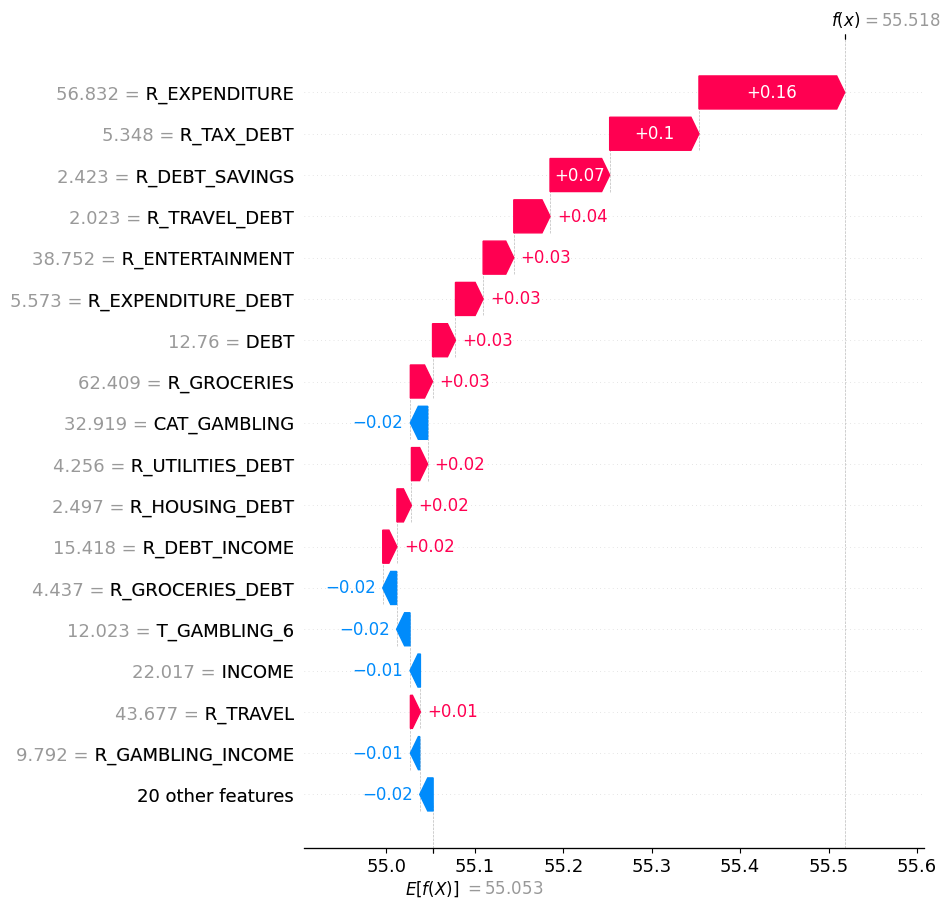

In [56]:
shap.plots.waterfall(100*shap_values.mean(axis=0), max_display=18)

In [21]:
shap.plots.force(shap_values[0:167])

In [22]:
mean_shap_values = np.abs(shap_values.values).mean(axis=0)

# Get feature names
feature_names = X_valid.columns  # Assuming X_valid is a pandas DataFrame

# Combine feature names with corresponding mean SHAP values
feature_importances = dict(zip(feature_names, mean_shap_values))

# Sort feature importances by magnitude
sorted_feature_importances = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)

# Print or process sorted feature importances
print("Feature Importances:")
for feature, importance in sorted_feature_importances:
    print(f"{feature}: {importance}")

Feature Importances:
R_DEBT_INCOME: 0.11736865031712683
R_EXPENDITURE: 0.011903809515043558
R_TAX_DEBT: 0.011305788496038237
R_ENTERTAINMENT: 0.008850037988784214
R_UTILITIES_DEBT: 0.007757137382270825
R_EXPENDITURE_DEBT: 0.005227764795407304
R_DEBT_SAVINGS: 0.004696879621987132
R_TRAVEL_DEBT: 0.004458907015963853
CAT_GAMBLING: 0.004085879568411592
R_ENTERTAINMENT_DEBT: 0.00406808222792632
T_GAMBLING_6: 0.003700066473194605
R_GROCERIES_DEBT: 0.002446147318648503
R_GROCERIES: 0.002180807692934326
R_GAMBLING_INCOME: 0.002125904402271798
INCOME: 0.0018929789219293148
R_TRAVEL: 0.001666614067232105
R_HEALTH_DEBT: 0.0013002626326262302
T_TRAVEL_12: 0.0010476754648724763
R_EXPENDITURE_INCOME: 0.0009213043241108826
R_HOUSING_DEBT: 0.0009130448370665413
DEBT: 0.0008663147320272098
T_TAX_12: 0.000758375639015122
T_ENTERTAINMENT_6: 0.0006560617760020236
T_EXPENDITURE_12: 0.0006351706083389574
T_CLOTHING_12: 0.0004457436404527732
R_TAX_SAVINGS: 0.0003704821039298802
R_TAX_INCOME: 0.00036717849134

In [33]:
a = np.array([x[1] for x in sorted_feature_importances])
a.cumsum() / a.sum()

array([0.57593653, 0.63434939, 0.68982772, 0.7332555 , 0.77132034,
       0.79697336, 0.82002129, 0.84190147, 0.86195118, 0.88191356,
       0.90007006, 0.91207348, 0.92277486, 0.93320683, 0.94249582,
       0.95067401, 0.9570545 , 0.96219552, 0.96671642, 0.9711968 ,
       0.97544787, 0.97916928, 0.98238862, 0.98550545, 0.98769274,
       0.98951073, 0.9913125 , 0.99302884, 0.99473449, 0.99602653,
       0.99689583, 0.99768042, 0.99842474, 0.99912362, 0.99960722,
       0.99987407, 1.        ])

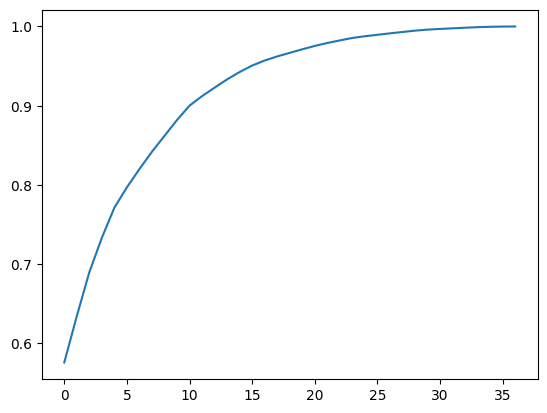

In [35]:
plt.plot(a.cumsum() / a.sum())

In [34]:
a.cumsum()

array([0.11736865, 0.12927246, 0.14057825, 0.14942829, 0.15718542,
       0.16241319, 0.16711007, 0.17156898, 0.17565485, 0.17972294,
       0.183423  , 0.18586915, 0.18804996, 0.19017586, 0.19206884,
       0.19373546, 0.19503572, 0.19608339, 0.1970047 , 0.19791774,
       0.19878406, 0.19954243, 0.2001985 , 0.20083367, 0.20127941,
       0.20164989, 0.20201707, 0.20236684, 0.20271443, 0.20297773,
       0.20315488, 0.20331477, 0.20346646, 0.20360888, 0.20370743,
       0.20376181, 0.20378747])

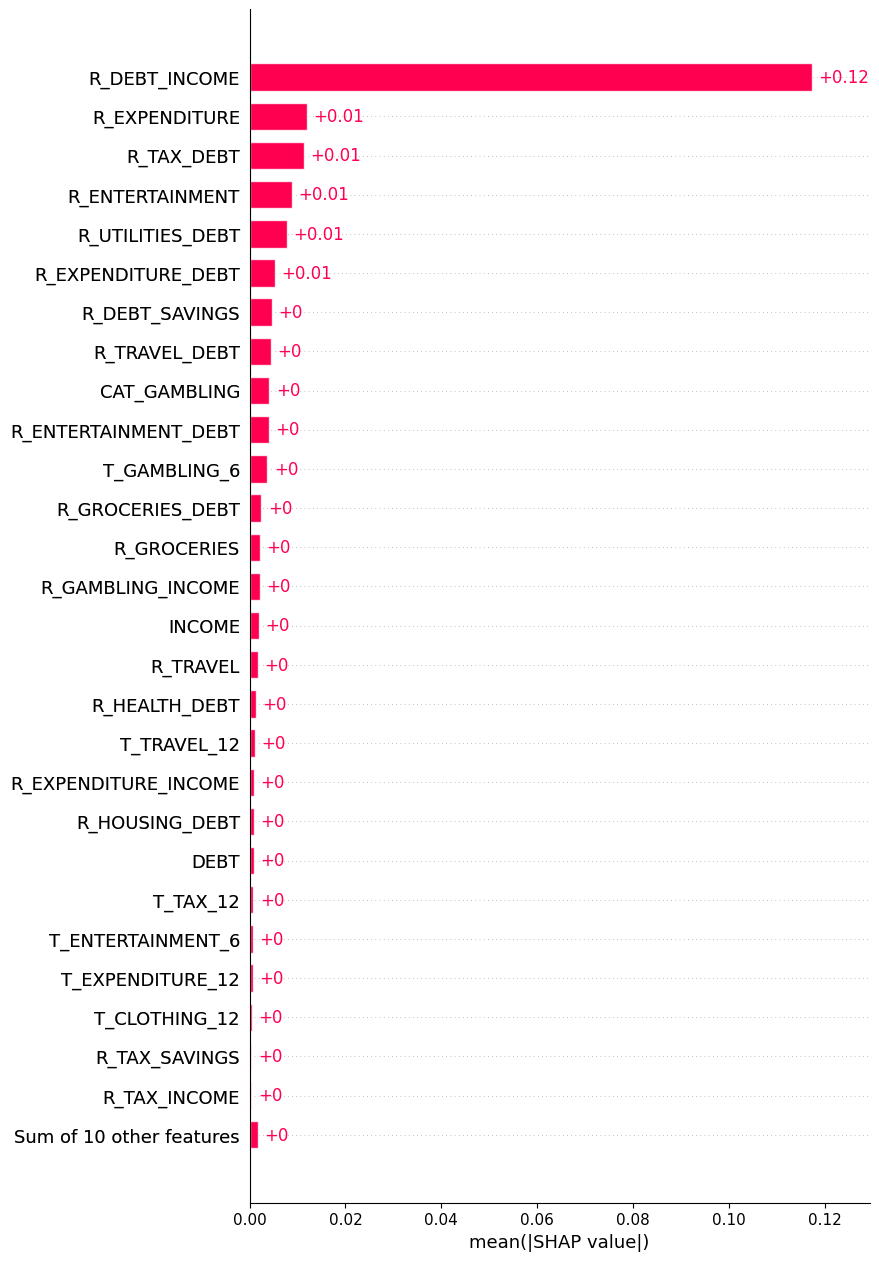

In [23]:
shap.plots.bar(shap_values,max_display=28)

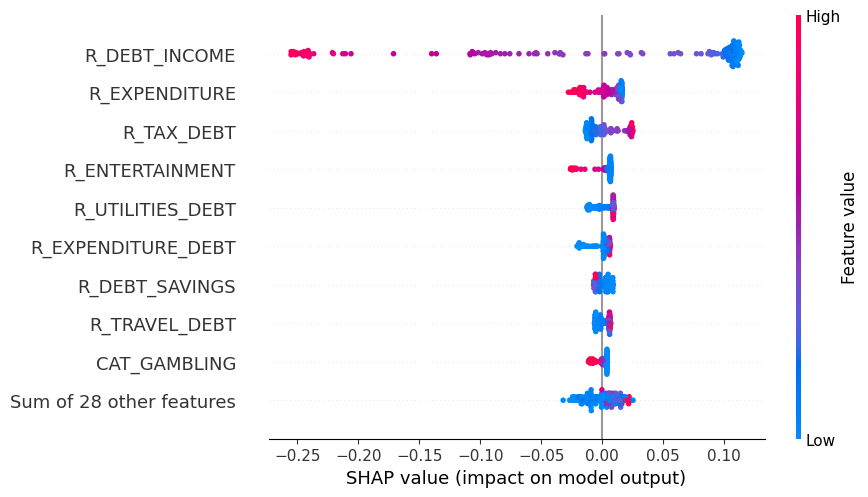

In [24]:
shap.plots.beeswarm(shap_values)

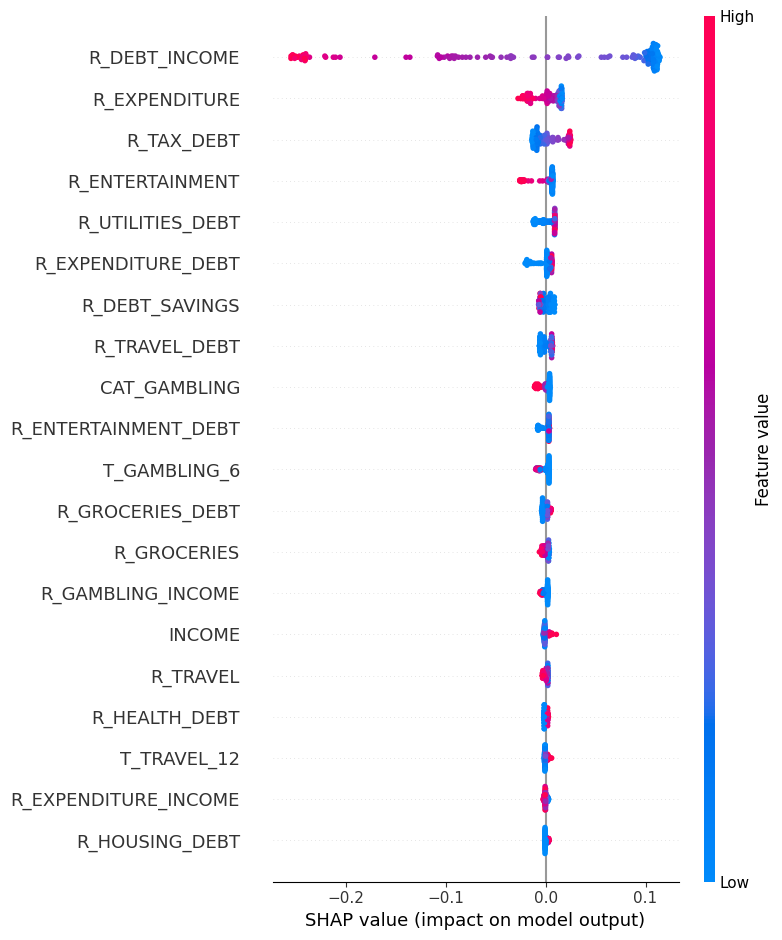

In [25]:


shap.summary_plot(shap_values, X_valid)



# Positive SHAP Values: When a feature has a positive SHAP value for certain observations, 
#     it means that in those cases, the feature's value has contributed to increasing the predicted credit score.
#     For example, a high income might generally be associated with a higher credit score, reflecting a borrower's ability to repay debts.

# Negative SHAP Values: Conversely, a negative SHAP value for the feature in other observations 
#     indicates that it has contributed to lowering the predicted credit score. An example might be 
#     the use of the same income feature but at a lower value, suggesting a lower capacity for debt repayment and therefore a lower credit score.

In [26]:
# Calculate prediction explanations for a single instance
instance_index = 0
instance_explanation = explainer.shap_values(X_valid.iloc[instance_index])

# Print prediction explanation for the instance
print("Prediction Explanation for Instance", instance_index)
print(instance_explanation)


/home/erikaramovich/Documents/MtqiZark/credit_score_prediction/venv/lib/python3.11/site-packages/catboost/core.py:937: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isinstance(data[0], Iterable):


CatBoostError: /src/catboost/catboost/libs/data/model_dataset_compatibility.cpp:72: Feature CAT_CREDIT_CARD is present in model but not in pool.

In [ ]:
# last Spo predcition scores
# {'learning_rate': 0.6033700598512344,
#  'depth': 4,
#  'l2_leaf_reg': 38.92268508672135,
#  'min_child_samples': 123,
#  'iterations': 497}

In [ ]:
print("Training set metrics:")
print(mean_squared_error(y_train, pred_train))
print(r2_score(y_train, pred_train))
print(mean_absolute_error(y_train, pred_train))
print(np.sqrt(mean_squared_error(y_train, pred_train)))

print("Validation set metrics:")
print(mean_squared_error(y_valid, pred_valid))
print(r2_score(y_valid, pred_valid))
print(mean_absolute_error(y_valid, pred_valid))
print(np.sqrt(mean_squared_error(y_valid, pred_valid)))

Training set metrics:
0.0033007569106272847
0.8083648988418621
0.04264708889757113
0.057452214149041156
Validation set metrics:
0.0038316607172604635
0.771700788589567
0.04460615947626148
0.06190040966956894


In [ ]:
# print("Training set metrics:")
# print(mean_squared_error(y_train, pred_train))
# print(r2_score(y_train, pred_train))
# print(mean_absolute_error(y_train, pred_train))
# print(np.sqrt(mean_squared_error(y_train, pred_train)))

# print("Validation set metrics:")
# print(mean_squared_error(y_valid, pred_valid))
# print(r2_score(y_valid, pred_valid))
# print(mean_absolute_error(y_valid, pred_valid))
# print(np.sqrt(mean_squared_error(y_valid, pred_valid)))


Training set metrics:
0.0020861356718066227
0.8788832890998062
0.03443580505288086
0.04567423422244343
Validation set metrics:
0.0035043265612778513
0.7912041150041146
0.041729216269541645
0.05919735265430247


In [ ]:
from preprocessing.minmax_scaler import MinMaxScaling

predicted = MinMaxScaling().inverse_transform(pred_valid)
actual = MinMaxScaling().inverse_transform(y_valid)
print(mean_squared_error(actual, predicted))
print(r2_score(actual, predicted))
print(mean_absolute_error(actual, predicted))
print(np.sqrt(mean_squared_error(actual, predicted)))

814.308367292911
0.771700788589567
20.563439518556546
28.53608885767128


In [ ]:
# Training set metrics:
# 0.0010818507548037424
# 0.9314771548203596
# 0.024995828691825792
# 0.03289149973479079
# Validation set metrics:
# 0.003781104669540127
# 0.7910454968147861
# 0.04361746360243078
# 0.061490687665207704

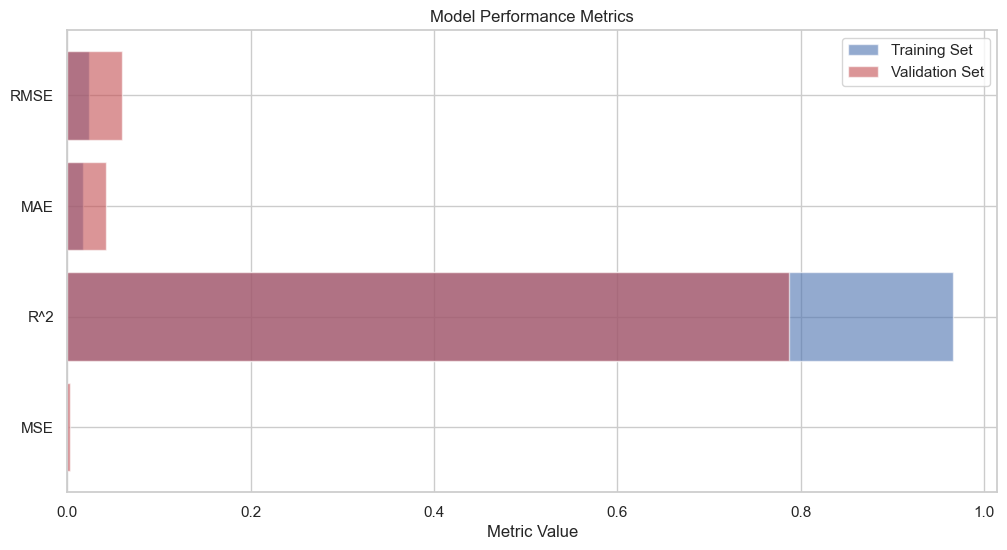

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define a function to plot the metrics
def plot_metrics(y_true_train, y_pred_train, y_true_valid, y_pred_valid):
    # Metrics calculation
    mse_train = mean_squared_error(y_true_train, y_pred_train)
    r2_train = r2_score(y_true_train, y_pred_train)
    mae_train = mean_absolute_error(y_true_train, y_pred_train)
    rmse_train = np.sqrt(mse_train)

    mse_valid = mean_squared_error(y_true_valid, y_pred_valid)
    r2_valid = r2_score(y_true_valid, y_pred_valid)
    mae_valid = mean_absolute_error(y_true_valid, y_pred_valid)
    rmse_valid = np.sqrt(mse_valid)

    # Plotting
    metrics = ['MSE', 'R^2', 'MAE', 'RMSE']
    train_values = [mse_train, r2_train, mae_train, rmse_train]
    valid_values = [mse_valid, r2_valid, mae_valid, rmse_valid]

    plt.figure(figsize=(12, 6))
    sns.set(style="whitegrid")
    plt.barh(metrics, train_values, color='b', alpha=0.6, label='Training Set')
    plt.barh(metrics, valid_values, color='r', alpha=0.6, label='Validation Set')

    plt.xlabel('Metric Value')
    plt.title('Model Performance Metrics')
    plt.legend()
    plt.show()

# Call the function with your prediction results
plot_metrics(y_train, pred_train, y_valid, pred_valid)


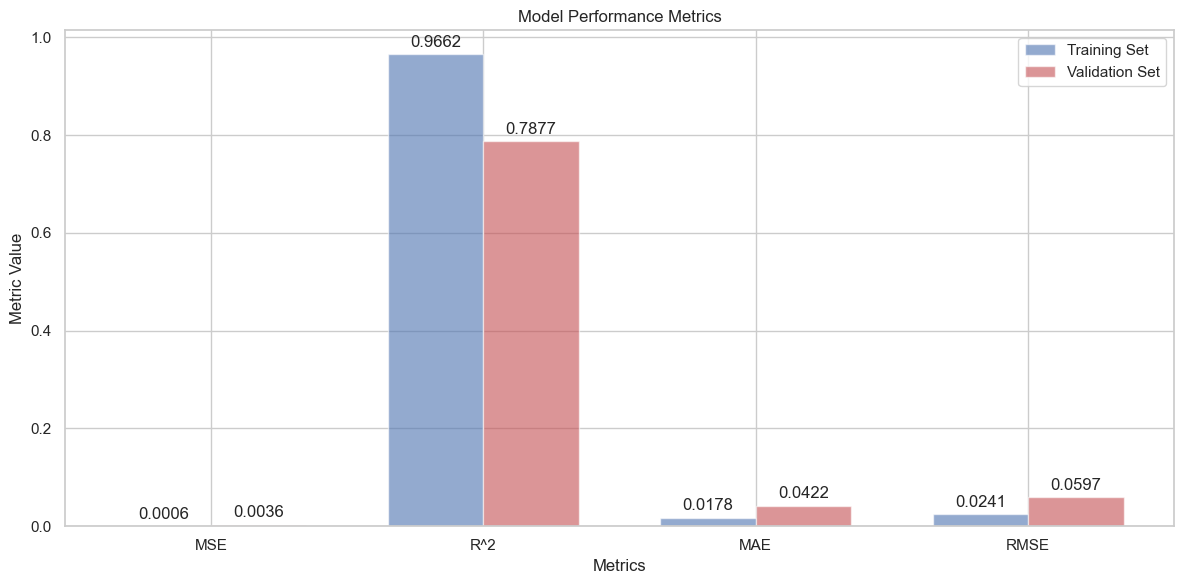

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Define a function to plot the metrics
def plot_metrics(y_true_train, y_pred_train, y_true_valid, y_pred_valid):
    # Metrics calculation
    mse_train = mean_squared_error(y_true_train, y_pred_train)
    r2_train = r2_score(y_true_train, y_pred_train)
    mae_train = mean_absolute_error(y_true_train, y_pred_train)
    rmse_train = np.sqrt(mse_train)

    mse_valid = mean_squared_error(y_true_valid, y_pred_valid)
    r2_valid = r2_score(y_true_valid, y_pred_valid)
    mae_valid = mean_absolute_error(y_true_valid, y_pred_valid)
    rmse_valid = np.sqrt(mse_valid)

    # Prepare data for plotting
    metrics = ['MSE', 'R^2', 'MAE', 'RMSE']
    train_values = [mse_train, r2_train, mae_train, rmse_train]
    valid_values = [mse_valid, r2_valid, mae_valid, rmse_valid]
    x = np.arange(len(metrics))  # the label locations
    width = 0.35  # the width of the bars

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 6))
    rects1 = ax.bar(x - width/2, train_values, width, label='Training Set', color='b', alpha=0.6)
    rects2 = ax.bar(x + width/2, valid_values, width, label='Validation Set', color='r', alpha=0.6)

    # Add labels, title, and legend
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Metric Value')
    ax.set_title('Model Performance Metrics')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()

    # Attach a text label above each bar in rects, displaying its height
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{:.4f}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()

    plt.show()

# Call the function with your prediction results
plot_metrics(y_train, pred_train, y_valid, pred_valid)


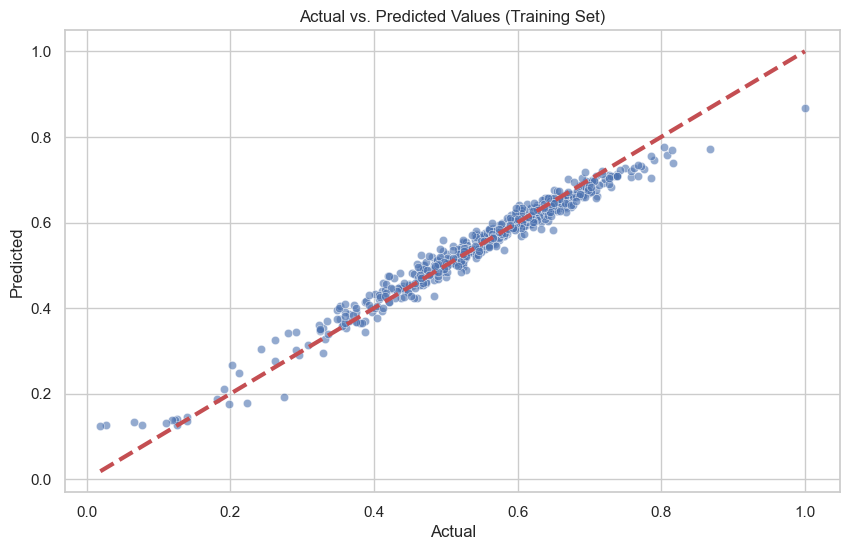

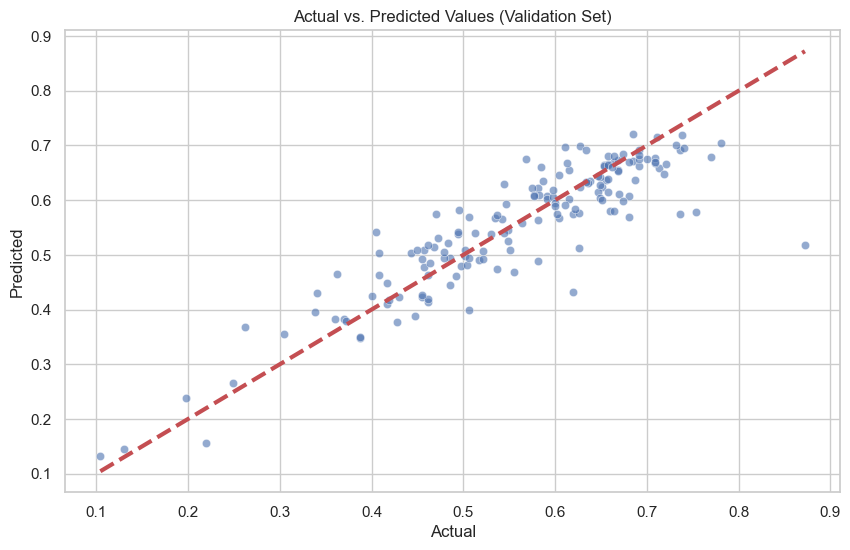

In [ ]:
def plot_actual_vs_predicted(y_true, y_pred, dataset_type='Training'):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=3) # Diagonal line
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Actual vs. Predicted Values ({dataset_type} Set)')
    plt.show()

plot_actual_vs_predicted(y_train, pred_train, 'Training')
plot_actual_vs_predicted(y_valid, pred_valid, 'Validation')


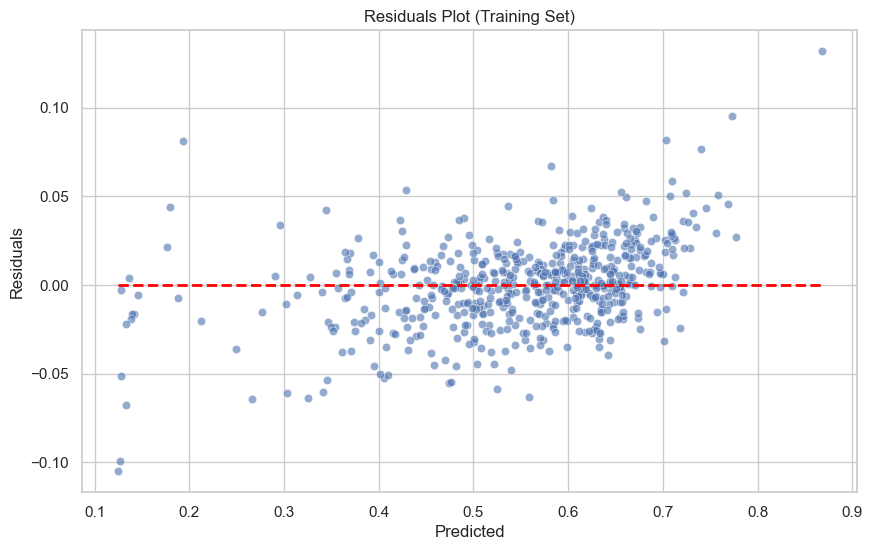

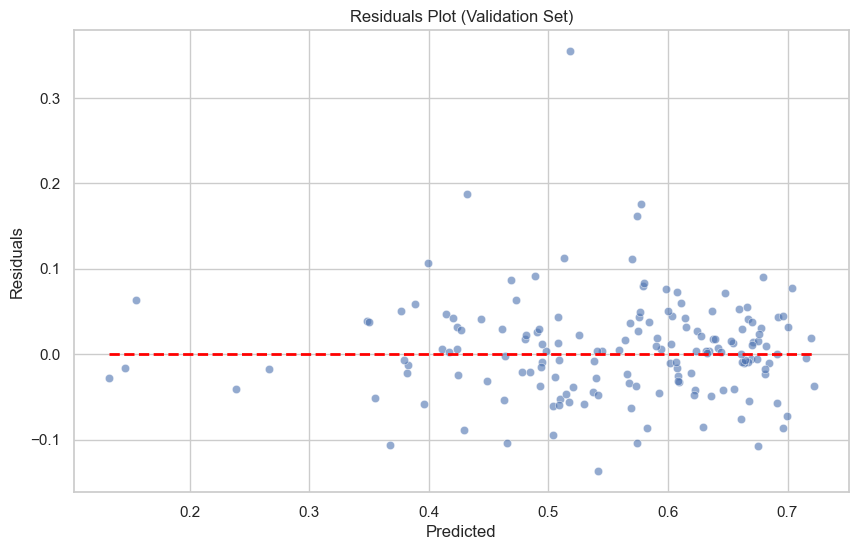

In [ ]:
def plot_residuals(y_true, y_pred, dataset_type='Training'):
    residuals = y_true - y_pred
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
    plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors='red', linestyles='--', lw=2)
    plt.xlabel('Predicted')
    plt.ylabel('Residuals')
    plt.title(f'Residuals Plot ({dataset_type} Set)')
    plt.show()

plot_residuals(y_train, pred_train, 'Training')
plot_residuals(y_valid, pred_valid, 'Validation')


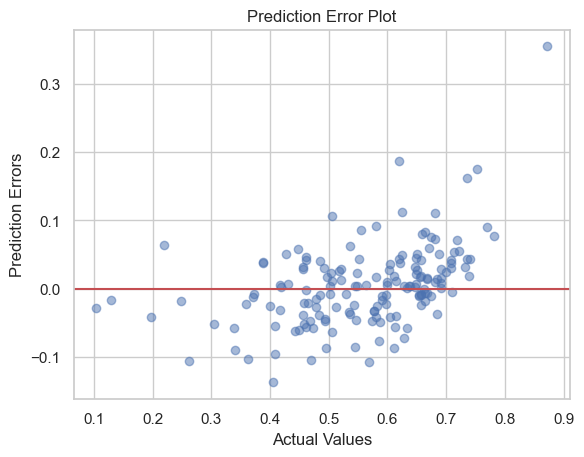

In [ ]:
import matplotlib.pyplot as plt

# Calculate prediction errors
errors = y_valid - pred_valid

# Plot prediction errors
plt.scatter(y_valid, errors, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Prediction Errors')
plt.title('Prediction Error Plot')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()
